## Описание

Курсовой проект для курса "Python для Data Science"
Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

**Целевая переменная:
Price**

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Импорт необходимых библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import pickle
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import seaborn as sns
sns.set();

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(true_values, pred_values):  
    """
    Функция для визуализации метрик качества
    
    """
    
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(7,7))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()],
             color="red", linestyle="--", alpha=0.5, linewidth=3)
    
    plt.xlabel('Предсказанное значение')
    plt.ylabel('Реальное значение')
    plt.title('Реальное и Предсказанное значение')
    plt.show()

In [4]:
def evaluate_preds_2(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Функция для визуализации метрик качества в сравнении
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(7,7))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Предсказанное значение')
    plt.ylabel('Реальное значение')
    plt.title('Реальное и Предсказанное значение')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Предсказанное значение')
    plt.ylabel('Реальное значение')
    plt.title('Реальное и Предсказанное значение')

    plt.show()

In [5]:
def cut_tail_quant(data, column_name):
    """
    Функция для заполнения неправельной площади медианой
    """
    data.loc[(data[column_name] > data[column_name].quantile(.95)) |\
             (data[column_name] < data[column_name].quantile(.01)), column_name] =\
              data[column_name].median()

### Загрузка данных

In [6]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Обзор дата-сета

In [7]:
print(f"Тренировачные данные:\t{df.shape[0]}\t строк и {df.shape[1]} столбцов")
print(f'Тестовые данные:\t{df_test.shape[0]}\t сторк и {df_test.shape[1]} столбцов')

Тренировачные данные:	10000	 строк и 20 столбцов
Тестовые данные:	5000	 сторк и 19 столбцов


In [8]:
df.info(memory_usage='deep')
# 3 признака (Ecology_2, Ecology_3, Shops_2) нужно преобразовать в бинарный формат 
# 2 признака (Жилая площадь и Healthcare_1) имеют пропуски, нужно будет их заполнить
# Переименовать столбец Helthcare_2 с ошибкой 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [9]:
df.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)

Удаляем столбец ID, так как он не несет смысловой нагрузки

In [10]:
del df['Id']
del df_test['Id']

In [11]:
df.head()
# Обратим внимание, что некоторые из признаков бинарные, поэтому стандартные описательные статистики 
# среднее, стандартное отклонение, медиана, квартили для них не имеют смысла. 
# В этом случае полезнее будет обычный подсчёт значений.

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0          35    2.0  47.981561   29.442751            6.0      7         9.0   
1          41    3.0  65.683640   40.049543            8.0      7         9.0   
2          53    2.0  44.947953   29.197612            0.0      8        12.0   
3          58    2.0  53.352981   52.731512            9.0      8        17.0   
4          99    1.0  39.649192   23.776169            7.0     11        12.0   

   HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  Social_3  \
0       1969   0.089040         B         B        33      7976         5   
1       1978   0.000070         B         B        46     10309         1   
2       1968   0.049637         B         B        34      7759         0   
3       1977   0.437885         B         B        23      5735         3   
4       1976   0.012339         B         B        35      5776         1   

   Healthcare_1  Healthcare_2  Shops_1 Shops_2          Price  
0           NaN             0       11       B  184966.930730  
1         240.0             1       16       B  300009.450063  
2         229.0             1        3       B  220925.908524  
3        1084.0             0        5       B  175616.227217  
4        2078.0             2        4       B  150226.531644

In [12]:
df.describe()
# Наглядно видно, что в основных признаках существуют выбросы (Rooms,Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear)
# Обработаем их в процесс работы далее.

DistrictId         Rooms        Square   LifeSquare  KitchenSquare  \
count  10000.000000  10000.000000  10000.000000  7887.000000   10000.000000   
mean      50.400800      1.890500     56.315775    37.199645       6.273300   
std       43.587592      0.839512     21.058732    86.241209      28.560917   
min        0.000000      0.000000      1.136859     0.370619       0.000000   
25%       20.000000      1.000000     41.774881    22.769832       1.000000   
50%       36.000000      2.000000     52.513310    32.781260       6.000000   
75%       75.000000      2.000000     65.900625    45.128803       9.000000   
max      209.000000     19.000000    641.065193  7480.592129    2014.000000   

              Floor    HouseFloor     HouseYear     Ecology_1      Social_1  \
count  10000.000000  10000.000000  1.000000e+04  10000.000000  10000.000000   
mean       8.526700     12.609400  3.990166e+03      0.118858     24.687000   
std        5.241148      6.775974  2.005003e+05      0.119025     17.532614   
min        1.000000      0.000000  1.910000e+03      0.000000      0.000000   
25%        4.000000      9.000000  1.974000e+03      0.017647      6.000000   
50%        7.000000     13.000000  1.977000e+03      0.075424     25.000000   
75%       12.000000     17.000000  2.001000e+03      0.195781     36.000000   
max       42.000000    117.000000  2.005201e+07      0.521867     74.000000   

           Social_2      Social_3  Healthcare_1  Healthcare_2       Shops_1  \
count  10000.000000  10000.000000   5202.000000  10000.000000  10000.000000   
mean    5352.157400      8.039200   1142.904460      1.319500      4.231300   
std     4006.799803     23.831875   1021.517264      1.493601      4.806341   
min      168.000000      0.000000      0.000000      0.000000      0.000000   
25%     1564.000000      0.000000    350.000000      0.000000      1.000000   
50%     5285.000000      2.000000    900.000000      1.000000      3.000000   
75%     7227.000000      5.000000   1548.000000      2.000000      6.000000   
max    19083.000000    141.000000   4849.000000      6.000000     23.000000   

               Price  
count   10000.000000  
mean   214138.857399  
std     92872.293865  
min     59174.778028  
25%    153872.633942  
50%    192269.644879  
75%    249135.462171  
max    633233.466570

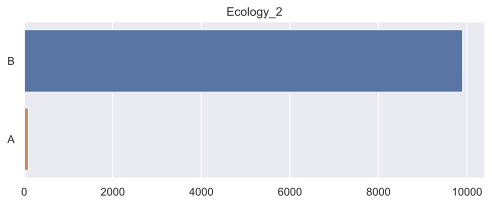

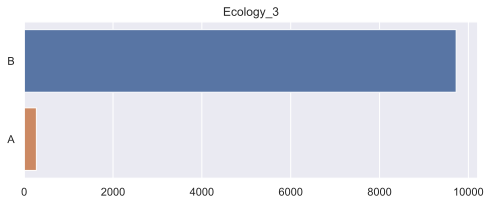

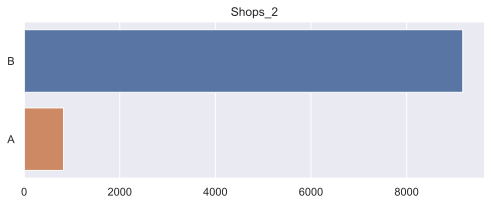

In [13]:
categorcial_varables = ['Ecology_2', 'Ecology_3', 'Shops_2']

for col in categorcial_varables:
    plt.figure(figsize=(7, 3))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

Так как в этих столбцах у нас только 2 категории, переводим их в 0 и 1

In [14]:
df['Ecology_2'] = np.where(df['Ecology_2'] == 'A', 1, 0)
df['Ecology_3'] = np.where(df['Ecology_3'] == 'A', 1, 0)
df['Shops_2'] = np.where(df['Shops_2'] == 'A', 1, 0)

In [15]:
# Повторяем для тестовой выборки
df_test['Ecology_2'] = np.where(df_test['Ecology_2'] == 'A', 1, 0)
df_test['Ecology_3'] = np.where(df_test['Ecology_3'] == 'A', 1, 0)
df_test['Shops_2'] = np.where(df_test['Shops_2'] == 'A', 1, 0)

### Исследуем основные признаки Rooms,Square, Floor, HouseFloor, HouseYear

**Rooms**

Text(0, 0.5, 'Количество')

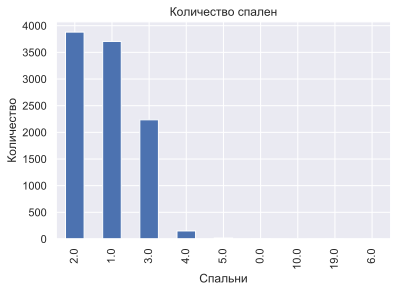

In [16]:
df['Rooms'].value_counts().plot(kind='bar')
plt.title('Количество спален')
plt.xlabel('Спальни')
plt.ylabel('Количество')

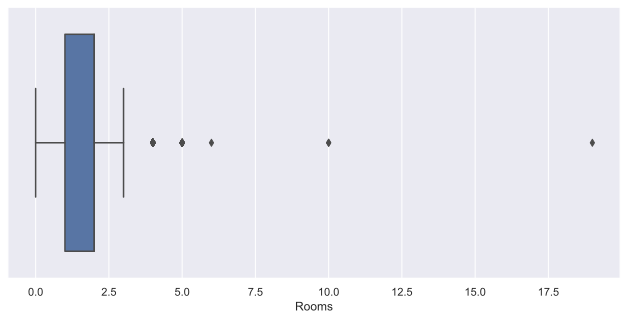

In [17]:
plt.figure(figsize=(11, 5))
sns.boxplot(df['Rooms']);

Основная доля количество спален сосредаточена в 2 и 1 количестве, так же мы видим с помощью boxplot выбросы начинаются с 4

**Square**

Text(0.5, 0, 'Square')

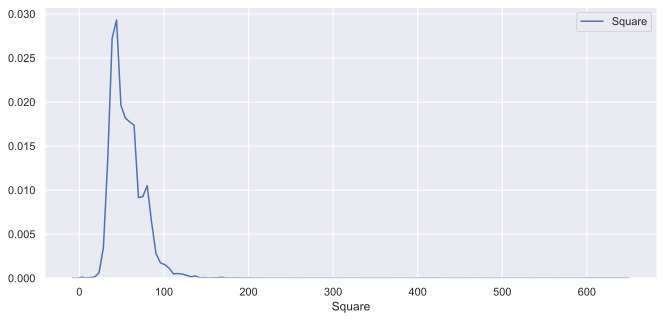

In [18]:
plt.figure(figsize = (11, 5))
plt.subplot
sns.kdeplot(df['Square'])
plt.xlabel('Square')

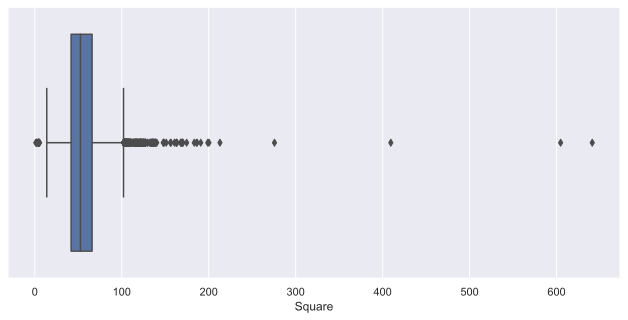

In [19]:
plt.figure(figsize=(11, 5))
sns.boxplot(df['Square']);

Доля всей площади сосредоточена от 30 кв/м до 100 кв/м, так же наблюдаем большие выбросы от 100 кв/м

**Floor**

Text(0, 0.5, 'Количество')

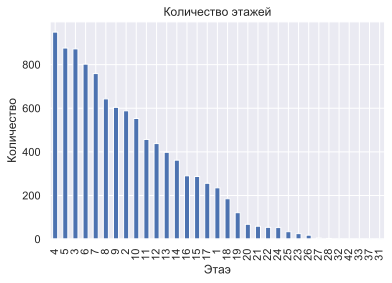

In [20]:
df['Floor'].value_counts().plot(kind='bar')
plt.title('Количество этажей')
plt.xlabel('Этаэ')
plt.ylabel('Количество')

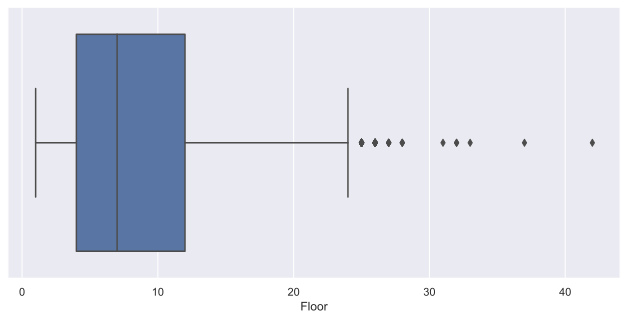

In [21]:
plt.figure(figsize=(11, 5))
sns.boxplot(df['Floor']);

Видим, что количество этажей в квартирах сосредаточенны от 4 до 12, после 25 идут явные выбросы.

#### HouseFloor

Text(0.5, 0, 'HouseFloor')

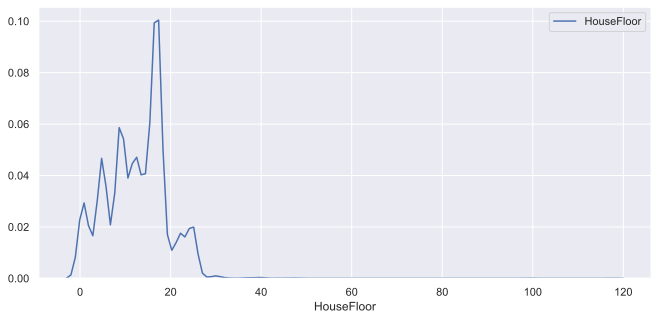

In [22]:
plt.figure(figsize = (11, 5))
plt.subplot
sns.kdeplot(df['HouseFloor'])
plt.xlabel('HouseFloor')

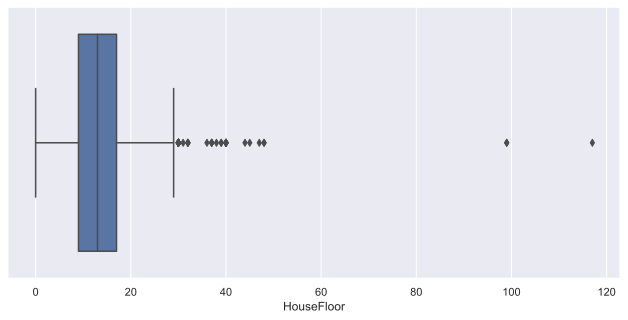

In [23]:
plt.figure(figsize=(11, 5))
sns.boxplot(df['HouseFloor']);

Основная доля представленных квартир расположенн от 10 этажа до 19-го. Выбросы наблюдаются с 24 этажа.

### HouseYear

Text(0.5, 0, 'HouseYear')

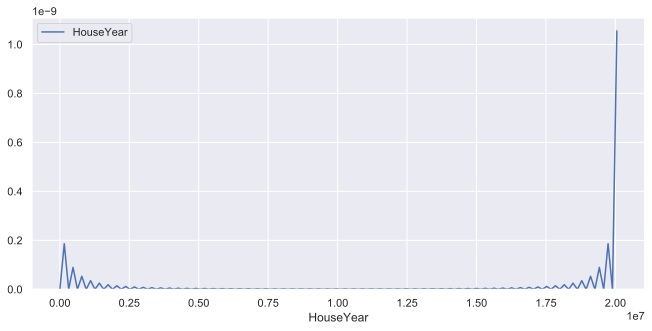

In [24]:
plt.figure(figsize = (11, 5))
plt.subplot
sns.kdeplot(df['HouseYear'])
plt.xlabel('HouseYear')

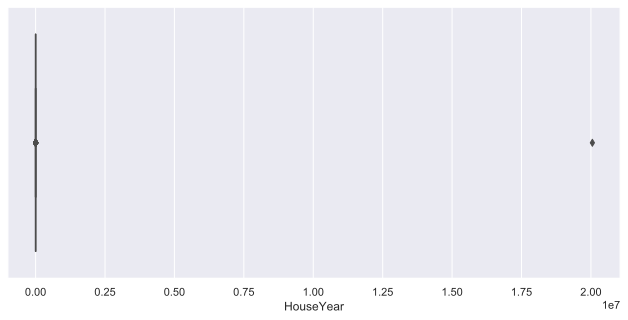

In [25]:
plt.figure(figsize=(11, 5))
sns.boxplot(df['HouseYear']);

Данный график нам к сожалению ни чего не показывает, поэтому воспользуемся другим подходом, и заодно и посмотрим как цена дома влияет на год постройки:

Text(0.5, 1.0, 'Распределения года посройки и цена квартиры')

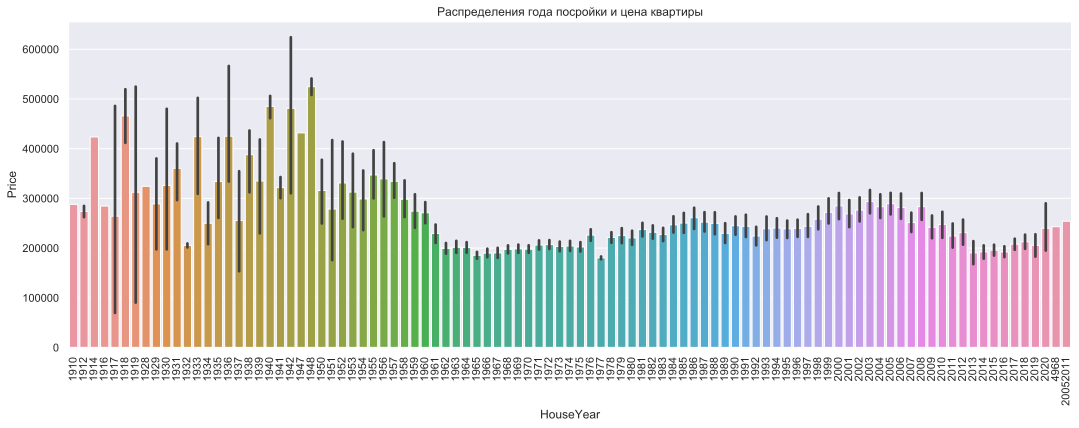

In [26]:
plt.figure(figsize=(18, 6))
sns.barplot(df['HouseYear'], df['Price'])
plt.xticks(rotation=90)
plt.title('Распределения года посройки и цена квартиры')

Видим, что есть два выброса после 2020 года, так же заметим, что цена более дорогая на квартирах старших лет. Возможно это из-за того что эти квартиры расположеные ближе к центру, где априории цена на недвижимость дороже.

### Анализ целевой переменной

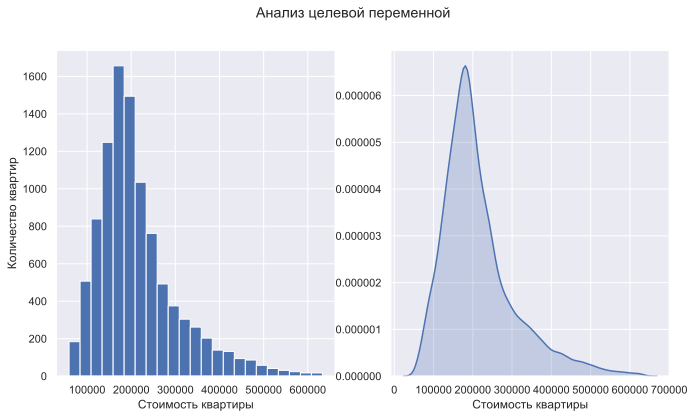

In [27]:
plt.figure(figsize = (11,6))
plt.subplot(121)
df['Price'].hist(bins=23)
plt.ylabel('Количество квартир')
plt.xlabel('Стоимость квартиры')
plt.subplot(122)

sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Стоимость квартиры')
plt.suptitle('Анализ целевой переменной')
plt.show()

In [28]:
#Нанесение статистик на график целевой переменной
price_mean = round(df['Price'].mean(), 2)
price_target = df['Price'].median()
price_mode = df['Price'].mode()[0]

price_mean, price_target, price_mode

(214138.86, 192269.64487934904, 59174.77802758122)

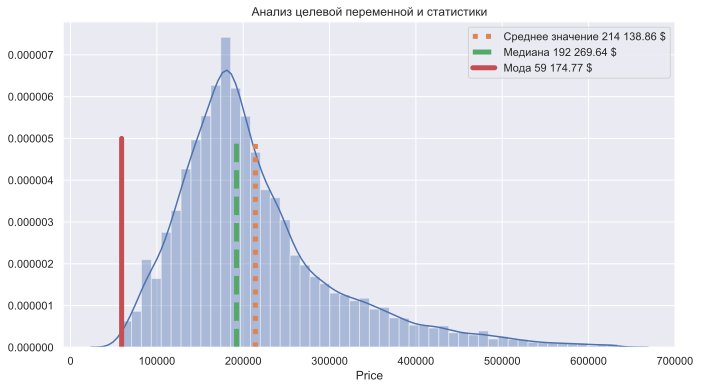

In [29]:
plt.figure(figsize = (11,6))
sns.distplot(df['Price'])
y = np.linspace(0, 0.000005, 100)

plt.plot([price_mean] * 100, y, label='Среднее значение 214 138.86 $', linestyle=':', linewidth=5)
plt.plot([price_target] * 100, y, label='Медиана 192 269.64 $', linestyle='--', linewidth=5)
plt.plot([price_mode] * 100, y, label='Мода 59 174.77 $', linestyle='-', linewidth=5)

plt.title('Анализ целевой переменной и статистики')
plt.legend()
plt.show()

### Анализ корреляций между признакми

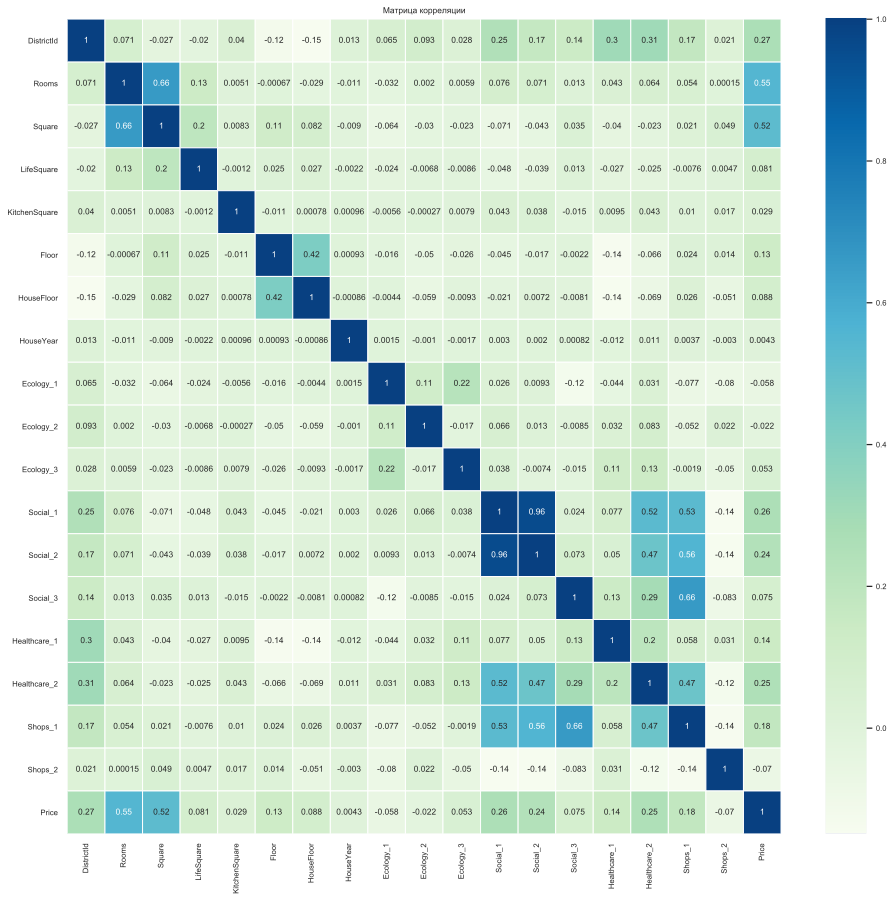

In [30]:
plt.figure(figsize = (16,15))
sns.set(font_scale=0.7)
sns.heatmap(df.corr(), annot=True, linewidths=1, cmap='GnBu')
plt.title('Матрица корреляции')
plt.show()

Видим почти полную линейную зависимость Social_1 и Social_2. Удалим лишний столбец

In [31]:
df.drop('Social_2', axis=1, inplace=True)

In [32]:
correlations_data = df.corr()['Price'].sort_values()
correlations_data

Shops_2         -0.070388
Ecology_1       -0.058381
Ecology_2       -0.022379
HouseYear        0.004305
KitchenSquare    0.028864
Ecology_3        0.052585
Social_3         0.074878
LifeSquare       0.081292
HouseFloor       0.088280
Floor            0.128715
Healthcare_1     0.138755
Shops_1          0.180876
Healthcare_2     0.253090
Social_1         0.263286
DistrictId       0.265100
Square           0.520075
Rooms            0.550291
Price            1.000000
Name: Price, dtype: float64

### Предобработка данных

**Обработка выбросов**

**HouseYear**

In [33]:
df.loc[df.HouseYear == 4968, 'HouseYear'] = 1968
df.loc[df.HouseYear == 20052011, 'HouseYear'] = 2005

**HouseFloor**

In [34]:
# Если этаж квартиры больше этажей в доме - приравниваем к числу этажей в доме
df.loc[df.Floor > df.HouseFloor, 'Floor'] = df.HouseFloor

df_test.loc[df_test.Floor > df_test.HouseFloor, 'Floor'] = df_test.HouseFloor

**Square, LifeSquare, KitchenSquare**

In [35]:
#Train
cut_tail_quant(df, 'Square')
cut_tail_quant(df, 'LifeSquare')
cut_tail_quant(df, 'KitchenSquare')

#Test
cut_tail_quant(df_test, 'Square')
cut_tail_quant(df_test, 'LifeSquare')
cut_tail_quant(df_test, 'KitchenSquare')

**Rooms**

In [36]:
df.loc[df['Rooms'].isin([10, 19]), 'Rooms'] = df['Rooms'].median()

df_test.loc[df_test['Rooms'].isin([10, 19]), 'Rooms'] = df_test['Rooms'].median()

**Обработка пропусков**

**LifeSquare**

In [37]:
df.loc[df.LifeSquare.isnull(), 'LifeSquare'] = df['LifeSquare'].median()

df_test.loc[df_test.LifeSquare.isnull(), 'LifeSquare'] = df_test['LifeSquare'].median()

**Healthcare_1**

In [38]:
df.loc[(df['Healthcare_1'] < 276) | (df['Healthcare_1'] > 1787), 'Healthcare_1'] = df['Healthcare_1'].median()

df_test.loc[(df_test['Healthcare_1'] < 276) | (df_test['Healthcare_1'] > 1787), 'Healthcare_1'] = df_test['Healthcare_1'].median()

In [39]:
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

In [40]:
df.isnull().any()

DistrictId       False
Rooms            False
Square           False
LifeSquare       False
KitchenSquare    False
Floor            False
HouseFloor       False
HouseYear        False
Ecology_1        False
Ecology_2        False
Ecology_3        False
Social_1         False
Social_3         False
Healthcare_1     False
Healthcare_2     False
Shops_1          False
Shops_2          False
Price            False
dtype: bool

### Создание новых признаков

**Средний возраст домов по районам**

In [41]:
gp = df.groupby(['DistrictId'])['HouseYear'].mean()
df['district_mean_year'] = df['DistrictId'].map(gp.to_dict())

df_test['district_mean_year'] = df_test['DistrictId'].map(gp.to_dict())

**Нормализованная сумма эко признаков по районам**

In [42]:
df['ecology_sum'] = np.log(1 + df['Ecology_1']) + np.log(1 + df['Ecology_2']) + np.log(1 + df['Ecology_3'])
gp = df.groupby(['DistrictId'])['ecology_sum'].mean()
df['district_ecology'] = df['DistrictId'].map(gp.to_dict())
df.drop('ecology_sum', axis=1, inplace=True)

df_test['district_ecology'] = df_test['DistrictId'].map(gp.to_dict())

**Медиана цены по районам**

In [43]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'med_price_by_district'})
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

df_test = df_test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

**Средняя площадь сгруппированная по количеству комнат и разница имеющейся площади с этим признаком**

In [44]:
gp = df.groupby(["Rooms"])["Square"].mean()
df["Mean_Square_by_rooms"] = df["Rooms"].map(gp.to_dict())
df["diff_square_and_mean_square_by_rooms"] = df["Square"] - df["Mean_Square_by_rooms"]

df_test["Mean_Square_by_rooms"] = df_test["Rooms"].map(gp.to_dict())
df_test["diff_square_and_mean_square_by_rooms"] = df_test["Square"] - df_test["Mean_Square_by_rooms"]

**Разница площади и жилой площади**

In [45]:
df['diff_square_lifesquare'] = df["Square"] - df["LifeSquare"]

df_test['diff_square_lifesquare'] = df_test["Square"] - df_test["LifeSquare"]

**Медиана цены на старое жилье относительно районов**

In [46]:
df['old_house'] = np.where(df['HouseYear'] < 1970, 1, 0)
med_price_by_district_old = df.groupby(['DistrictId', 'old_house'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'med_price_old'})

df = df.merge(med_price_by_district_old, on=['DistrictId', 'old_house'], how='left')

df_test['old_house'] = np.where(df_test['HouseYear'] < 1970, 1, 0)
df_test = df_test.merge(med_price_by_district_old, on=['DistrictId', 'old_house'], how='left')

In [47]:
df_test.loc[df_test.med_price_by_district.isnull(), 'med_price_by_district'] = df_test['med_price_by_district'].median()
df_test.loc[df_test.med_price_old.isnull(), 'med_price_old'] = df_test['med_price_old'].median()

### Моделирование

**Отбор признаков**

In [48]:
col = ['med_price_by_district', 'med_price_old', 'diff_square_and_mean_square_by_rooms', 'Square', 'Rooms', 'HouseYear',
 'district_mean_year', 'LifeSquare', 'KitchenSquare', 'diff_square_lifesquare', 'Ecology_1', 'district_ecology', 'HouseFloor',
 'Social_3', 'Healthcare_1', 'DistrictId', 'Social_1', 'Floor', 'Price']

In [49]:
df_no_cheap = df[df.Price > 100000][col]

In [50]:
X = df_no_cheap
Y = df_no_cheap['Price']
X = X.drop('Price', axis = 1)

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)

In [52]:
gbr = GradientBoostingRegressor(n_estimators=840, 
                                max_depth=3, 
                                learning_rate=0.1, 
                                min_samples_split=3, 
                                max_features=5, 
                                random_state=42, 
                                min_samples_leaf=5)

In [53]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=840,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
predict_y_gbr_train = gbr.predict(X_train)
base_score = r2(y_train, predict_y_gbr_train)

In [55]:
predict_y_gbr_valid = gbr.predict(X_valid)
r2(y_valid, predict_y_gbr_valid)

0.7955849298230997

R2:	0.796
MAE:	25655.355
MSE:	1721510099.336


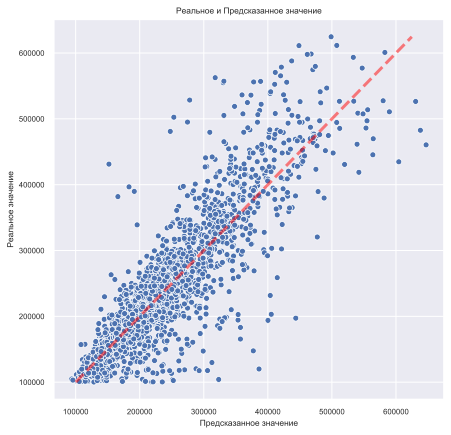

In [57]:
evaluate_preds(y_valid, predict_y_gbr_valid)

R2:	0.909
MAE:	17738.769
MSE:	723200551.674


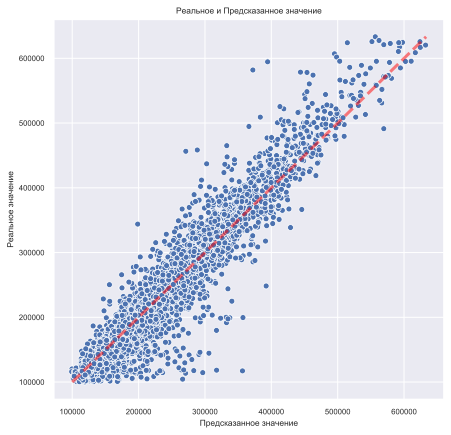

In [58]:
evaluate_preds(y_train, predict_y_gbr_train)

In [59]:
X = df[col]
Y = df['Price']
X = X.drop('Price', axis = 1)

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)

In [62]:
predict_y_gbr_train = gbr.predict(X_train)
base_score = r2(y_train, predict_y_gbr_train)

In [63]:
predict_y_gbr_valid = gbr.predict(X_valid)
r2(y_valid, predict_y_gbr_valid)

0.8113143705243597

Train R2:	0.823
Test R2:	0.811


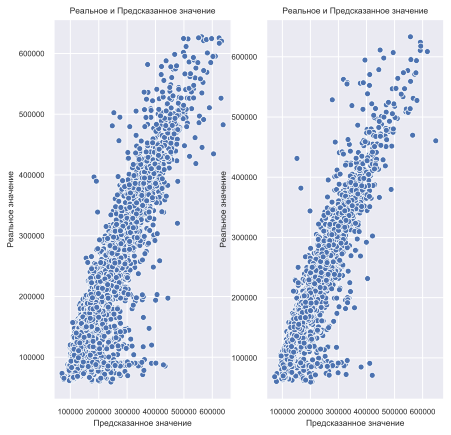

In [64]:
evaluate_preds_2(y_train, predict_y_gbr_train, y_valid, predict_y_gbr_valid)

In [65]:
col1 =[
 'med_price_by_district',
 'med_price_old',
 'diff_square_and_mean_square_by_rooms',
 'Square',
 'Rooms',
 'HouseYear',
 'district_mean_year',
 'LifeSquare',
 'KitchenSquare',
 'diff_square_lifesquare',
 'Ecology_1',
 'district_ecology',
 'HouseFloor',
 'Social_3',
 'Healthcare_1',
 'DistrictId',
 'Social_1',
 'Floor'
]

In [68]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DistrictId                            5000 non-null   int64  
 1   Rooms                                 5000 non-null   float64
 2   Square                                5000 non-null   float64
 3   LifeSquare                            5000 non-null   float64
 4   KitchenSquare                         5000 non-null   float64
 5   Floor                                 5000 non-null   float64
 6   HouseFloor                            5000 non-null   float64
 7   HouseYear                             5000 non-null   int64  
 8   Ecology_1                             5000 non-null   float64
 9   Ecology_2                             5000 non-null   int32  
 10  Ecology_3                             5000 non-null   int32  
 11  Social_1         

In [69]:
df_test.loc[df_test['district_mean_year'].isnull(), 'district_mean_year'] = df_test['district_mean_year'].median()
df_test.loc[df_test['district_ecology'].isnull(), 'district_ecology'] = df_test['district_ecology'].median()
df_test.loc[df_test['Mean_Square_by_rooms'].isnull(), 'Mean_Square_by_rooms'] = df_test['Mean_Square_by_rooms'].median()
df_test.loc[df_test['diff_square_and_mean_square_by_rooms'].isnull(), 'diff_square_and_mean_square_by_rooms'] = df_test['diff_square_and_mean_square_by_rooms'].median()

In [70]:
df_test.isnull().any()

DistrictId                              False
Rooms                                   False
Square                                  False
LifeSquare                              False
KitchenSquare                           False
Floor                                   False
HouseFloor                              False
HouseYear                               False
Ecology_1                               False
Ecology_2                               False
Ecology_3                               False
Social_1                                False
Social_2                                False
Social_3                                False
Healthcare_1                            False
Helthcare_2                             False
Shops_1                                 False
Shops_2                                 False
district_mean_year                      False
district_ecology                        False
med_price_by_district                   False
Mean_Square_by_rooms              

In [71]:
predict_y_gbr_test = gbr.predict(df_test[col1])

In [72]:
result = pd.DataFrame(predict_y_gbr_test, columns=['Price'])
df_t = pd.read_csv('test.csv')
final_result = pd.concat([df_t['Id'], result],axis=1).rename(columns={0:'Price'})

In [73]:
final_result

Id          Price
0       725  158794.784711
1     15856  240993.291266
2      5480  301455.416552
3     15664  311180.768184
4     14275  133217.562115
...     ...            ...
4995   8180  253627.767818
4996   4695  130527.050491
4997   5783  330812.652337
4998   4780  185528.784087
4999  12504  178053.785438

[5000 rows x 2 columns]

In [74]:
final_result.to_csv('SerebryakovMM_predictions.csv',index=None)